# NEON Canopy Height Model to Biomass at Niwot Ridge

## Applying the NEON tutorial from SJER to NIWO

    SJER = San Joaquin Experimental Range

    NIWO = Niwot Ridge Mountain Research Station

The code in this notebook is taken and adapted from NEON Tutorials: 

- https://www.neonscience.org/resources/learning-hub/tutorials/calc-biomass-py

    "In this tutorial, we will calculate the biomass for a section of the SJER site. We will be using the Canopy Height Model discrete LiDAR data product as well as field data collected by the TOS group at NEON. This tutorial will calculate Biomass for individual trees in the forest."

Working with NEON imagery in Python: 

- https://www.neonscience.org/resources/learning-hub/tutorials/plot-neon-rgb-py

In [1]:
# Import libraries
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

# Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

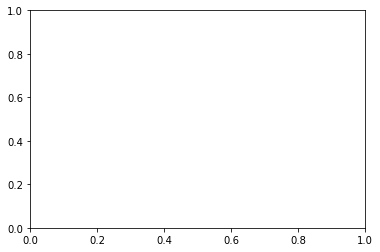

In [13]:
# Define custom functions 


# Define plot band array function
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

    
# Define a function that will allow us to output GeoTIFF files.
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

    
# NEON Image functions
def RGBraster2array(RGB_geotif):
    """RGBraster2array reads in a NEON AOP geotif file and returns 
    a numpy array, and header containing associated metadata with spatial information.
    --------
    Parameters
        RGB_geotif -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    array:
        numpy array of geotif values
    metadata:
        dictionary containing the following metadata (all strings):
            array_rows
            array_cols
            bands
            driver
            projection
            geotransform 
            pixelWidth 
            pixelHeight 
            extent
            noDataValue  
            scaleFactor 
    --------
    Example Execution:
    --------
    RGB_geotif = '2017_SERC_2_368000_4306000_image.tif'
    RGBcam_array, RGBcam_metadata = RGBraster2array(RGB_geotif) """

    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata

def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):

    '''plot_band_array reads in and plots a single band or an rgb band combination of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots array of single band or RGB if given a 3-band 
    --------
    Example:
    --------
    plot_band_array(SERC_RGBcam_array, 
                    SERC_RGBcam_metadata['extent'],
                    (1,255),
                    title='SERC RGB Camera Tile',
                    cbar='off')'''

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

In [3]:
# Create output directory for intermediate images and figures
if not os.path.exists('./figures/'):
    os.makedirs('figures/')

In [4]:
# Define a path to the CHM file 
chm_file = 'data/NEON_D13_NIWO_DP3_452000_4432000_CHM.tif'

In [12]:
# Define a path to the corresponding RGB file
rgb_file = 'data/2020_NIWO_4_452000_4432000_image.tif'

In [5]:
# Get info from CHM file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")

In [6]:
# Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

# Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)

# Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

# Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

In [7]:
# Find min and max height values in the CHM image 
chm_stats = chm_raster.ComputeStatistics(0)
chm_metadata = chm_raster.GetMetadata()


chm_min_height = chm_stats[0]
chm_max_height = chm_stats[1]

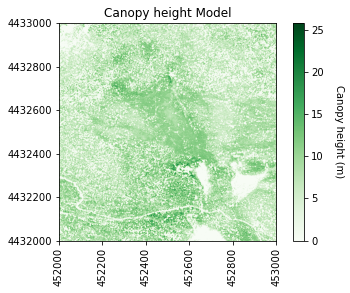

In [8]:
# Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

# Plot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[chm_min_height, chm_max_height])

# Save the CHM to an image file
plt.savefig('figures/'+ just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

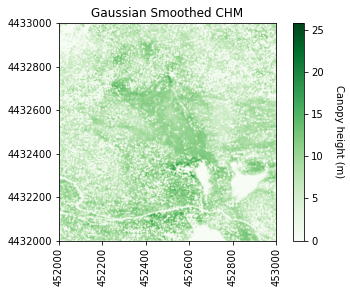

In [11]:
# Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

# Plot the smoothed CHM 
plot_band_array(chm_array_smooth, image_extent, 'Gaussian Smoothed CHM','Canopy height (m)','Greens',[chm_min_height, chm_max_height])

In [ ]:
# Save the smoothed CHM
array2raster('figures/chm_filter.tif',(xMin,yMax),1,-1,np.array(chm_array_smooth/10000,dtype=float),32611)

In [ ]:
# Try a cropped version of the CHM to see the effect of the smoothing

## RGB

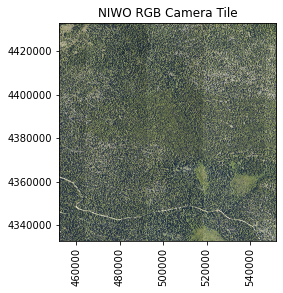

In [16]:
# Read the RGB image file and convert to an array
rgb_array, rgb_metadata = RGBraster2array(rgb_file)

# View the dimensions of the RGB array
#rgb_array.shape

# Plot the RGB image for context 
plot_band_array(rgb_array,
                rgb_metadata['extent'],
                (1,255),
                title='NIWO RGB Camera Tile',
                cbar='off') 

In [20]:
# Crop the image 
import fiona
with fiona.open('data/NIWO_020_plot.gpkg', layer='NIWO_020_plot') as layer:
    for feature in layer:
        print(feature['geometry'])
        
#subplot = fiona.open('data/NIWO_020_plot.gpkg', layer='NIWO_020_plot')
#print(subplot['geometry'])

import geopandas as gpd
subplot_extent = gpd.read_file('data/NIWO_020_plot.gpkg')

{'type': 'MultiPolygon', 'coordinates': [[[(-105.55501679628942, 40.041478817587056), (-105.55454792926915, 40.041481062540626), (-105.55454500970619, 40.04112068991806), (-105.55501387425831, 40.04111844499299), (-105.55501679628942, 40.041478817587056)]]]}


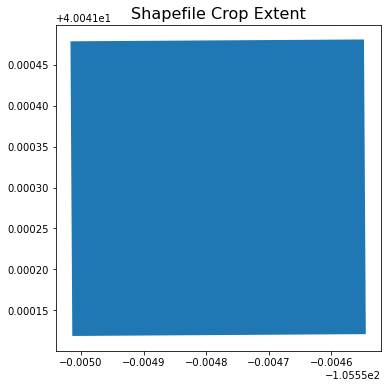

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

subplot_extent.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

In [22]:
# make sure the raster and vector files have the same CRS 
print('crop extent crs: ', subplot_extent.crs)
print('raster crs: ', rgb_array.rio.crs)

crop extent crs:  epsg:4326


AttributeError: 'numpy.ndarray' object has no attribute 'rio'